>**Сеть фитнес-центров «Культурист-датасаентист»**  

---

**анализ и подготовка плана действий по удержанию клиентов**

# ТЗ <a name="TZ"></a>

В течении подготовительного этапа в отделе по работе с клиентами «Культуриста-датасаентиста» переведены клиентские анкеты в электронный вид. Задача — провести анализ и подготовить план действий по удержанию клиентов

Состав данных:



источник данных: отдел по работе с клиентами «Культуриста-датасаентиста»

# вспомогательные технические ф-ции <a name="support_func"></a>

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans


from sklearn.metrics import accuracy_score , precision_score , recall_score

from scipy.cluster.hierarchy import dendrogram, linkage 


In [ ]:
def gist_stroy(df_in,bins, column, locus = 'upper center', cut_znach = True):

  df = df_in.copy()

  if cut_znach:
    df['1'] = pd.cut(df[column], bins)
  else:
    df['1'] = df[column]

  df_rab = df[df['Churn'] == 0].groupby('1')['1'].count().to_frame()
  df_rab_2 = df[df['Churn'] == 1].groupby('1')['1'].count().to_frame()

  fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,6))

  ax.set_title('распределение для ' +  column)
  ax.bar(x= df_rab.index.astype('str') , height= df_rab['1'], width =0.2, label='оставшиеся клиенты', align='center', )
  ax.bar(x= df_rab_2.index.astype('str') , height= df_rab_2['1'], width =0.2, label='ушедшие клиенты', align='edge',)
 
  ax.set_xlabel('группы разбиения характеристики')
  ax.set_ylabel('кол-во клиентов в группе, шт.')

  ax.legend(loc = locus)

  plt.xticks(rotation=-45, ha='left')

  for bar in ax.patches:
      ax.annotate(bar.get_height(), 
                    (bar.get_x() + bar.get_width() / 2, 
                      bar.get_height()), ha='center', va='center',
                    size=15, xytext=(0, 8),
                    textcoords='offset points')

  plt.show()

In [ ]:
def rasp_graf():
  for col in df.drop('cluster_mean_5_values',axis = 1).columns:


    fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(22,5))

    for i in range(5):
      ax[i].hist(df[df['cluster_mean_5_values'] == i][col])

      ax[i].set_title('кластер №' + str(i))
    
      ax[i].set_xlabel('хар-ка')
      ax[i].set_ylabel('частота выпадения')
      ax[i].xaxis.set_tick_params(rotation=30)
      #ax[0].legend()
      ax[i].grid()


    fig.suptitle('распределение признака ' + col, fontsize=15)
    plt.show()


# 1) загрузка данных <a name="data_load"></a>

In [ ]:
try:
  df=pd.read_csv('/datasets/gym_churn.csv')
except:
  df=pd.read_csv('https://.../gym_churn.csv')

In [ ]:
df.head(3)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [ ]:
print('уникальные значения:')
for i in df.columns:
  print(i , ':', df[i].unique())


уникальные значения:
gender : [1 0]
Near_Location : [1 0]
Partner : [1 0]
Promo_friends : [1 0]
Phone : [0 1]
Contract_period : [ 6 12  1]
Group_visits : [1 0]
Age : [29 31 28 33 26 34 32 30 23 27 35 25 36 24 21 37 22 19 20 38 39 18 41]
Avg_additional_charges_total : [ 14.22747042 113.20293765 129.44847933 ...  78.25054157  61.91265691
 178.86181361]
Month_to_end_contract : [ 5. 12.  1.  6.  3. 10. 11.  9.  4.  7.  8.  2.]
Lifetime : [ 3  7  2  0  1 11  4  8 14  6  5 15 12 21 10 20  9 13 17 16 24 22 31 26
 23 18 19 27 29]
Avg_class_frequency_total : [0.02039795 1.92293606 1.85909835 ... 2.78614636 1.63010814 1.10183221]
Avg_class_frequency_current_month : [0.         1.91024352 1.73650189 ... 2.8314395  1.59623664 1.03526976]
Churn : [0 1]


In [ ]:
#проверим: нет ли абонентов, у которых срок до окончания абонемента меньше срока всего абонемента
(df['Contract_period'] - df['Month_to_end_contract']).min()

0.0

На первый взгляд- данные предоставлены без пропусков, с верными типами данных. Значения в колонках соответствуют ожидаемым значениям (нет необъяснимых значений (например 3 вида пола и т.д.)

Т.к. база весит 0,5 Мб, то заменять типы столбцов на более "маловесящие" не будем, поскольку на вычислительные мощности современных машин это не оказывает значимого воздействия. Сыкономим толику электричества при переобщёте данных.

#2) исследовательский анализ данных <a name="data_reserch"></a>

построим искусственную метрику: какова текущая метрика интенсивности посещения относительно среднемесячной (ищем рост или падение в отногсительных единицах).

Граничные случаи (избавляемся от деления на 0):

- В случае, если среднемесячная частота посещений была равна 0, а частота посещений в последний месяц больше 0, то такие значения мы приравняем к "1" (искуственное значение- надо подбирать). 
 
- В случае, если среднемесячная частота посещений была равна 0, и частота посещений в последний месяц равна 0, то такие значения мы приравняем к "0" (т.е. изменений нет).

- В случае, если текущая частота равна 0, а среднемесячная больше 0, то фор-ла автоматически выдаст значение "-1". Поэтому, в первом случае начально значение - "1"


In [ ]:
df['variation_avg_class_frequency'] = (-df['Avg_class_frequency_total'] + df['Avg_class_frequency_current_month']) / (df['Avg_class_frequency_total'])

#избавление от деления на 0:
df['variation_avg_class_frequency']  = df.apply(
    lambda row: 1 if ( (row['Avg_class_frequency_total'] == 0) & (row['Avg_class_frequency_current_month'] > 0)) else row['variation_avg_class_frequency'] 
    , axis=1 
    )
df['variation_avg_class_frequency']  = df.apply(
    lambda row: 0 if ( (row['Avg_class_frequency_total'] == 0) & (row['Avg_class_frequency_current_month'] == 0)) else row['variation_avg_class_frequency']
     , axis=1 
    )



In [ ]:
#df.head()
#df['decrease_avg_class_frequency'].max()
#df['decrease_avg_class_frequency'].min()
#df[df['decrease_avg_class_frequency'].isnull()].head(10)


ввели новыйй признак, посмотрим кк он себя чувствует при прогнозировании

## 2.1) оценка наличия отсутствующих признаков, среднего  значения параметров и СКО <a name="data_reserch_1"></a>

In [ ]:
df.isnull().mean()

gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits                         0.0
Age                                  0.0
Avg_additional_charges_total         0.0
Month_to_end_contract                0.0
Lifetime                             0.0
Avg_class_frequency_total            0.0
Avg_class_frequency_current_month    0.0
Churn                                0.0
variation_avg_class_frequency        0.0
dtype: float64

провусков е обнаружено (0% пропусков)

In [ ]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,variation_avg_class_frequency
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250,-0.076881
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521,0.328993
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000,-0.097736
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000,-0.011488
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000,0.028979
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000,6.244537


зачастую, разброс, по численному значению, близок к среднему значению. Если учесть тот факт, что множство колонок у нас распределены бинарным образом- то можем сказать, что бинарные признаки представлены в схожем кол-ве

Средний клиент выглядит так: 
- перекоса по полу не наблюдается
- клиент живёт около фитнес центра
- половина клиента пришло от компании партнёра (и, если учеть, что многие живут около фитнес центра- значит они и работают около дома - тут возникает вопрос- либо что такое "около", либо что это за место. гдебольшинство живут около работы. Может это сильно спеецифический фитнес центр)
- в основном пришедших по приглашению от другого клента -нет
- почти все оставили свой телефон
- полугодовой контракт- самый популярный
- многие (почти половина) ходят на групповые занятия)- цифры близки к партнёрской программе - возможно люди из одной компании ходят на одни секции - интересно было бы посмотреть
- 29- средний возраст
- доп услуги на 147 денежных единиц - интересно сравнить со стоимостью среднего контракта
- 4 месяца до окончания (учитывая средний контракт в пол года- нормльная цифра)
- 4 месяца плодотворного сотрудничества - тоже коррелирует со средним сроком контракта
- в среднем в месяц посещает чуть меньше 2 раз в неделю (так же как и в текущем месяце)- какой-то малый показатель- либо это очень специфический фитнес центр, либо нацеленый на очень специфических клиентов
- оттекают примерно четверть клиентов- сложно сказать без понимания рынка- это много или мало


интересно сравнить эти показатели с показателями других фитнес центров подобного сегмента - это даст более полную картину текущего состояния анализируемого предприятия (в том числе отношения клиентов к конкретному фитнес центру).

---

## 2.2) оценка средних значений признако для 2-ух искомых признаков <a name="data_reserch_2"></a>

In [ ]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,variation_avg_class_frequency
Churn,,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882,0.015591
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546,-0.333030


из данного распределения можем сказать, что люди, пришедшие по партнёрским программам, пришедших по программе "приведи друга", записавшиеся на большой период времени, посещающие групповые занятия, те, кто больше тратят на прочие услуги фитнес центра, те у кого осталось больше месяцев до окончания абонемента, "старожилы" фитнес клуба, те кто чаще ходят вообще и в последний наблюдаемый месяц в частности - остаются чаще других

можно сказать, что эти столбцы (описанные выше) будут иметь большее значение (больший вес) на прогнастическую модель чем остальные столбцы

## 2.3) распределения признаков <a name="data_reserch_3"></a>

In [ ]:
#df

посмотрим на бинарные признаки:

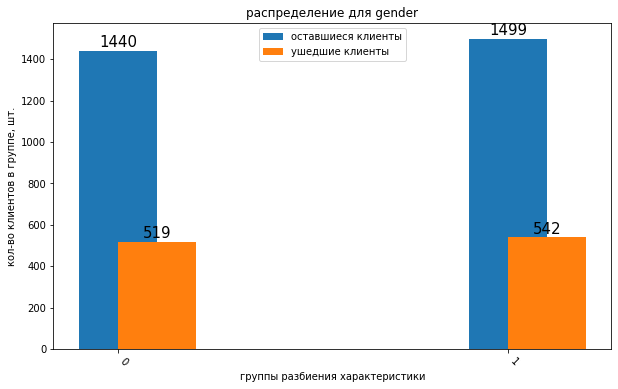

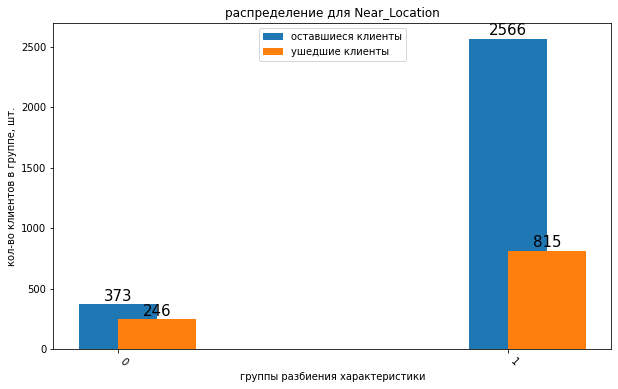

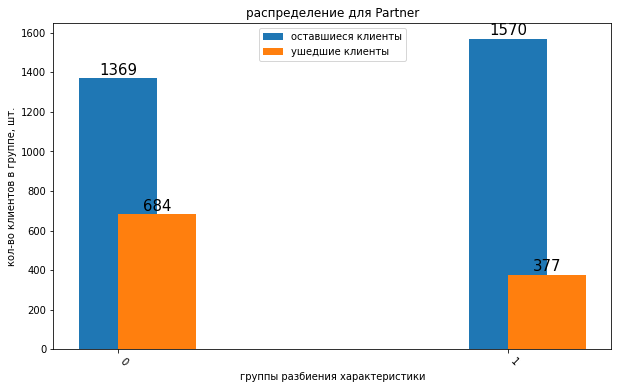

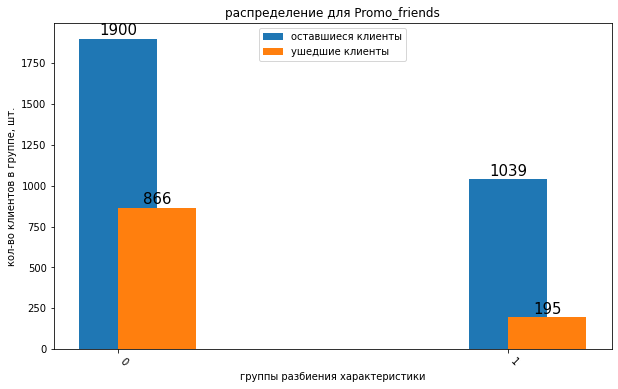

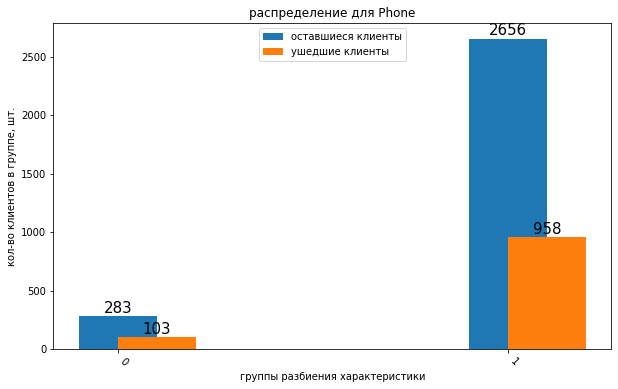

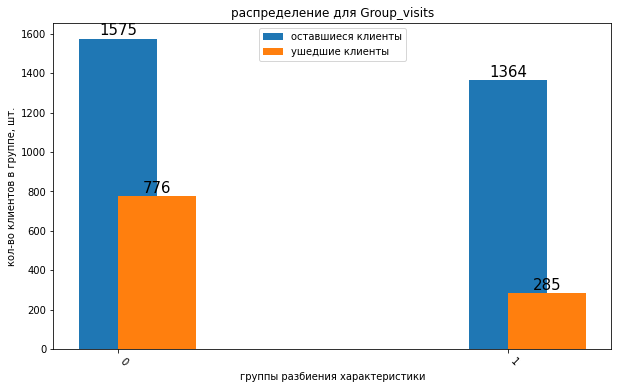

In [ ]:
for i in ('gender','Near_Location','Partner','Promo_friends','Phone','Group_visits'):
  gist_stroy(df,2, i , 'upper center', False )

Итого: мы можем увидеть, что распределение по полу равномерное для оставшихся и отошедших клиентов. Если человек работает или остался рядом с клубом- то он более вероятно останется, люди из промо программы остаются более вероятно. При наличии телефона в базе-  люди остаются чаще (вероятно идёт рекламны обзвон). Так же, если человек ходит на групповые занятия- он реже покидает клуб.

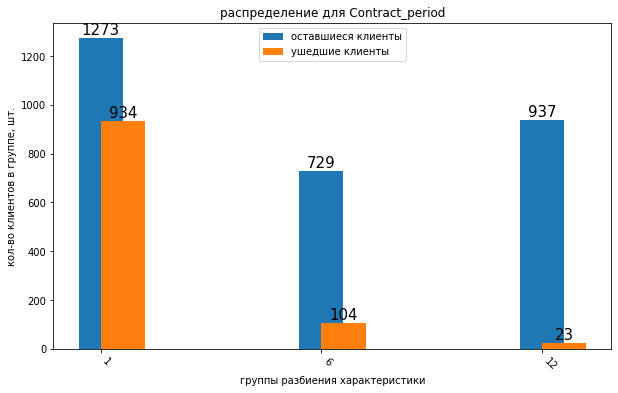

In [ ]:
gist_stroy(df,3, 'Contract_period' ,'upper center', False )

можем наблюдать, что заключение договора на долгосрочный период влечёт более долгое потребление услуги (если пришёл на большую работу, то это на долго)

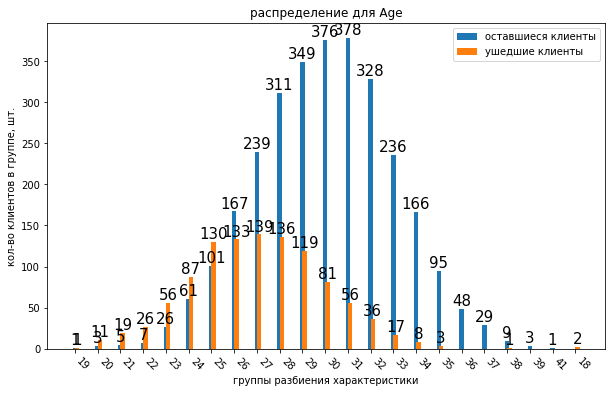

In [ ]:
gist_stroy(df,df['Age'].nunique(), 'Age' , 'upper right', False)

возраста имеют, приблизхительно, нормальное распределение, но средний возраст отходящего клиента- 27 лет, а у оставшегося- 31 год.

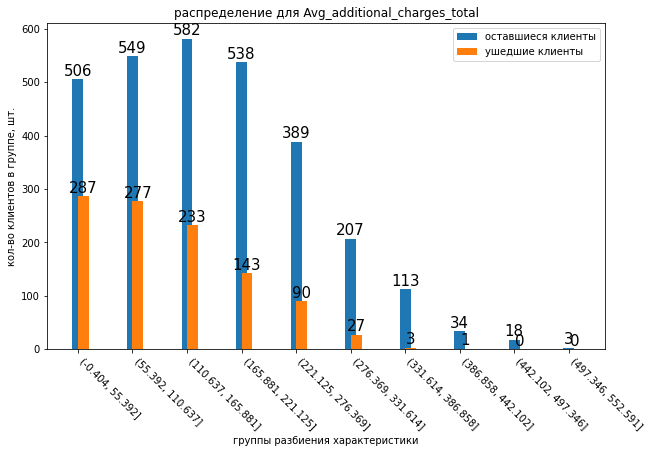

In [ ]:
gist_stroy(df,10, 'Avg_additional_charges_total' , 'upper right')

можем наблюдать, что те кто пришёл заниматься "по серьёзному" тратит, в среднем, больше средств на доп услуги

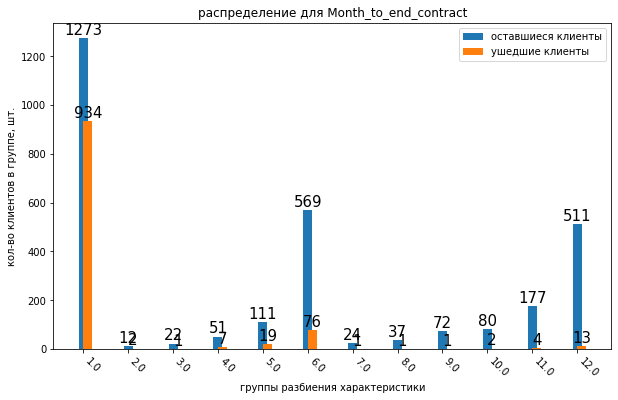

In [ ]:
gist_stroy(df,df['Month_to_end_contract'].nunique(), 'Month_to_end_contract' , 'upper right', False)

в основном отходят клиенты, у которых близится срок окончания контракта

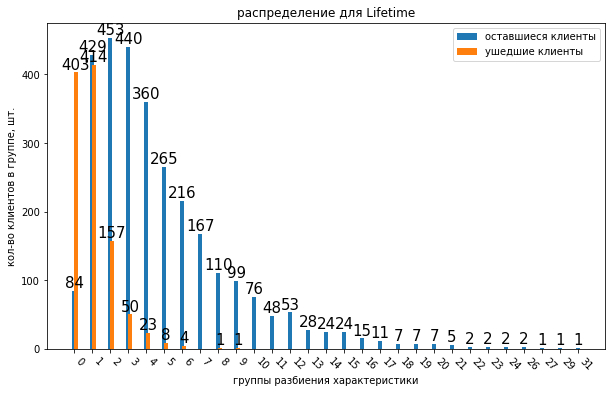

In [ ]:
gist_stroy(df,df['Lifetime'].nunique(), 'Lifetime' , 'upper right', False)

соответсвенно, кто больше ходит (кто раньше обращался) тот реже уходит

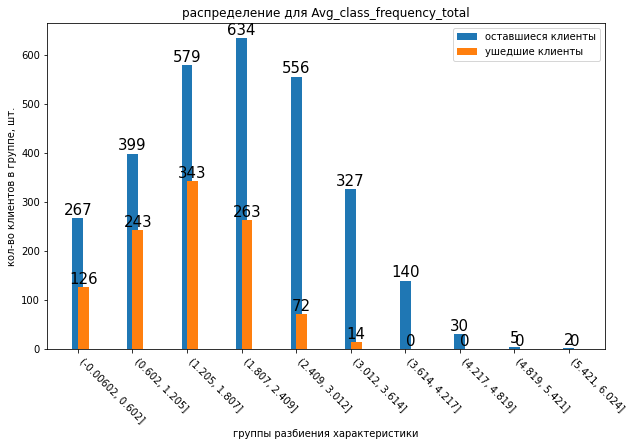

In [ ]:
gist_stroy(df,10, 'Avg_class_frequency_total' , 'upper right', )

кто чаще ходит, тот реже уходит

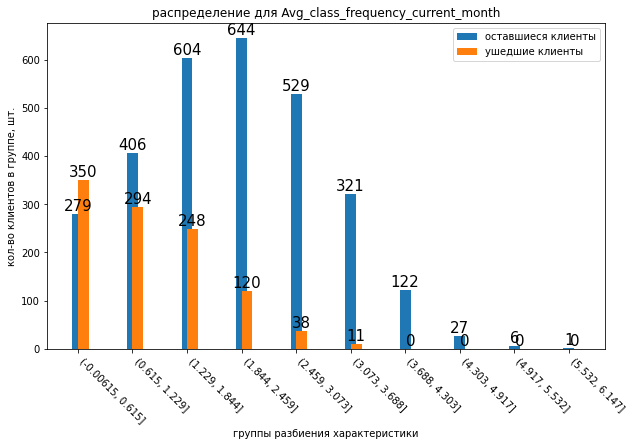

In [ ]:
gist_stroy(df,10, 'Avg_class_frequency_current_month' , 'upper right', )

при резком снижении в последний месяц- вероятно уйдёт

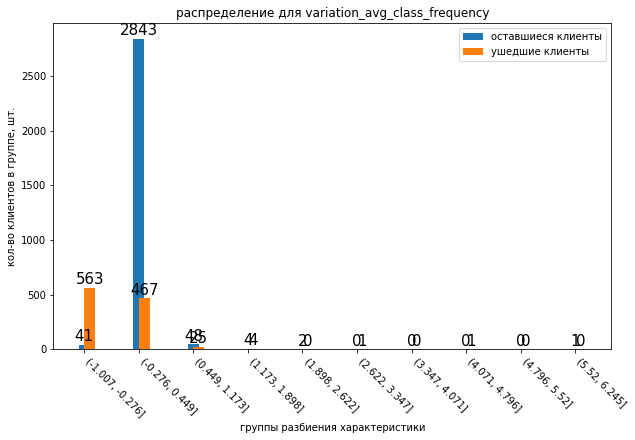

In [ ]:
gist_stroy(df,10, 'variation_avg_class_frequency' , 'upper right', )

при резком снижении в последний месяц- вероятно уйдёт

Ещё раз посмотрели на основные влияющие признаки. Так же увидели нормальность распределения некоторых небинарных признаков. В основном, чаще остаются те, кто больше тратит, дольше ходит и не сбавляет темп (логично, чёрт побери!)

## 2.4) корреляция признаков <a name="data_corr"></a>

общая матрица корреляции

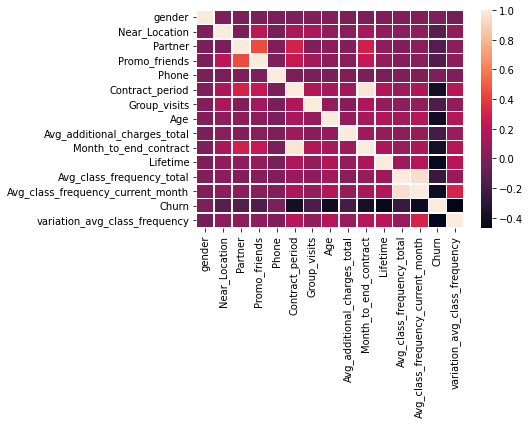

In [ ]:
sns.heatmap(
    df.corr()
    #,annot=True
    ,linewidths=.5
    
    )

рабочая матрица корреляции

корреляция для столбца 'Churn':

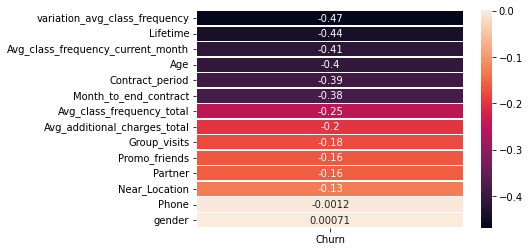

In [ ]:
sns.heatmap(
    df.corr()['Churn'].to_frame().drop('Churn',axis = 0).sort_values('Churn')
    ,annot=True
    ,linewidths=.5
    
    )

как мы можем увидеть- самые влияющие факторы (с самым меньшим абсолютным числом) - относительное изменение частоты посещения, время с момента первого посещения и текущая частота посещения. 

Мало влияющие факторы- наличие телефона в базе и половая принадлежость


# 3) модель прогнозирования оттока клиентов <a name="data_model"></a>

In [ ]:
X=df.drop('Churn', axis = 1)
y = df['Churn']

---

In [ ]:
y.value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

наблюдаем перекос в сторону оставшихся клиентов

---

разбили данные иобнаружили перекос в целевом показателе

# 3.1) разбивка данных <a name="data_split"></a>

разобъём данные в пропорции 80-20:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

---
---
избавимся от перекоса, т.к. нас интересует оптимизация по метрики recall т.к. нам важно найти всех оттекающих клиентов и не беспокоить (не тратить деньги) на неотткающих:

In [ ]:
vremena = y_train.to_frame().join(X_train)
pd.Series(vremena['Churn']).value_counts()

0    2337
1     863
Name: Churn, dtype: int64

In [ ]:
vrem2 = pd.concat([vremena[vremena['Churn'] == 1] , vremena[vremena['Churn'] == 0].sample(863, random_state=0) ])

In [ ]:
pd.Series(vrem2['Churn']).value_counts()

1    863
0    863
Name: Churn, dtype: int64

перекос в тренировочных данных поправили, правда с потерей данных. Теперь обратно всё разобъём

In [ ]:
X_train =vrem2.drop('Churn', axis = 1)
y_train = vrem2['Churn']

подготовили данные для дальнейшего построения моделей

# 3.2) обучение моделей <a name="model_learning"></a>

### Логистическая регрессия

In [ ]:
model_log_reg = LogisticRegression(solver='liblinear',  random_state=0)

In [ ]:
model_log_reg.fit(X_train , y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
prediction_log_reg = model_log_reg.predict(X_test)

посмотрим на коэффициенты модели:

In [ ]:
dff= pd.DataFrame({'feature': X_train.columns , 'coeff_abs': model_log_reg.coef_[0] })
dff['coeff_abs'] = dff['coeff_abs'].abs()
dff.sort_values('coeff_abs', ascending= False).reset_index(drop = True)

,feature,coeff_abs
0,Avg_class_frequency_current_month,3.127609
1,Avg_class_frequency_total,2.444778
2,Lifetime,0.896217
3,Promo_friends,0.648755
4,Group_visits,0.637643
5,Phone,0.588059
6,variation_avg_class_frequency,0.467371
7,Contract_period,0.182211
8,Near_Location,0.165087
9,Age,0.132896


построили модель логистической регрессии для бинарной классификации  и определили основные влияющие факторы

### Случайный лес

т.к. нам важно найти всех оттекающих клиентов и не беспокоить (не тратить деньги) на неотткающих будем оптимизировать по метрике recall

In [ ]:
#зададим параметры для лесного массива. Оптимизировать будем по Recal
criteriy = 0.00001
step = 1
min_tree = 2
max_tree = 50   # по опыту

recall_forest_best = 0
n_estimators_best = 1

найдём оптимальное кол-во деревьев в лесу (т.к. модель склонна к переобучению):

In [ ]:
for i in tqdm(range(min_tree, max_tree, step)):
  model_forest = RandomForestClassifier(n_estimators = i, random_state=0)
  model_forest.fit(X_train , y_train)
  prediction_forest = model_forest.predict(X_test)

  recall_forest = recall_score (y_test, prediction_forest)
  
  #if (recall_forest < recall_forest_best):
  #  break
  #if (((recall_forest - recall_forest_best) / recall_forest_best) < criteriy  ):
  #  break
  if ( recall_forest  > recall_forest_best  ):
    recall_forest_best = recall_forest
    n_estimators_best = i

  #recall_forest_best = recall_forest
  #n_estimators_best = i


clear_output()
print('\nлучший лес по кол-ву деревьев:',n_estimators_best)
print('лучший recall:',recall_forest_best)
print('кол-во исследованных деревьев в лесу: от', min_tree, 'до', max_tree)



лучший лес по кол-ву деревьев: 31
лучший recall: 0.9545454545454546
кол-во исследованных деревьев в лесу: от 2 до 50


In [ ]:
model_forest = RandomForestClassifier(n_estimators = n_estimators_best-1, random_state=0)
model_forest.fit(X_train , y_train)
prediction_forest = model_forest.predict(X_test)
axxx = recall_score (y_test, prediction_forest)

model_forest = RandomForestClassifier(n_estimators = n_estimators_best+1, random_state=0)
model_forest.fit(X_train , y_train)
prediction_forest = model_forest.predict(X_test)
ayyy = recall_score (y_test, prediction_forest)

model_forest = RandomForestClassifier(n_estimators = n_estimators_best, random_state=0)
model_forest.fit(X_train , y_train)
prediction_forest = model_forest.predict(X_test)
azzz = recall_score (y_test, prediction_forest)

print('recall c кол-вом деревьев (recall_forest_best - 1):',axxx)
print('recall c кол-вом деревьев (recall_forest_best + 1):',ayyy)
print('recall c кол-вом деревьев recall_forest_best :',azzz)

recall c кол-вом деревьев (recall_forest_best - 1): 0.9444444444444444
recall c кол-вом деревьев (recall_forest_best + 1): 0.9444444444444444
recall c кол-вом деревьев recall_forest_best : 0.9545454545454546


In [ ]:
step = 1
min_tree = 2
max_tree = 50   # по опыту
n_estimators_best = 1
precision_forest_best = 0

for i in tqdm(range(min_tree, max_tree, step)):
  model_forest = RandomForestClassifier(n_estimators = i, random_state=0)
  model_forest.fit(X_train , y_train)
  prediction_forest = model_forest.predict(X_test)

  precision_forest = precision_score (y_test, prediction_forest)
  
  #if (recall_forest < recall_forest_best):
  #  break
  #if (((recall_forest - recall_forest_best) / recall_forest_best) < criteriy  ):
  #  break
  if ( precision_forest  > precision_forest_best  ):
    precision_forest_best = precision_forest
    n_estimators_best = i

  #recall_forest_best = recall_forest
  #n_estimators_best = i


clear_output()
print('\nлучший лес по кол-ву деревьев:',n_estimators_best)
print('лучший precision:',precision_forest_best)
print('кол-во исследованных деревьев в лесу: от', min_tree, 'до', max_tree)


лучший лес по кол-ву деревьев: 12
лучший precision: 0.8732394366197183
кол-во исследованных деревьев в лесу: от 2 до 50


In [ ]:
model_forest = RandomForestClassifier(n_estimators = n_estimators_best-1, random_state=0)
model_forest.fit(X_train , y_train)
prediction_forest = model_forest.predict(X_test)
axxx = precision_score (y_test, prediction_forest)

model_forest = RandomForestClassifier(n_estimators = n_estimators_best+1, random_state=0)
model_forest.fit(X_train , y_train)
prediction_forest = model_forest.predict(X_test)
ayyy = precision_score (y_test, prediction_forest)

model_forest = RandomForestClassifier(n_estimators = n_estimators_best, random_state=0)
model_forest.fit(X_train , y_train)
prediction_forest = model_forest.predict(X_test)
azzz = precision_score (y_test, prediction_forest)

print('recall c кол-вом деревьев (precision_forest_best - 1):',axxx)
print('recall c кол-вом деревьев (precision_forest_best + 1):',ayyy)
print('recall c кол-вом деревьев precision_forest_best :',azzz)

recall c кол-вом деревьев (precision_forest_best - 1): 0.8378378378378378
recall c кол-вом деревьев (precision_forest_best + 1): 0.8538812785388128
recall c кол-вом деревьев precision_forest_best : 0.8732394366197183


итоговая модель:

In [ ]:
model_forest = RandomForestClassifier(n_estimators = n_estimators_best, random_state=0)
model_forest.fit(X_train , y_train)
prediction_forest = model_forest.predict(X_test)

посмотрим на коэффициенты модели:

In [ ]:
dff2= pd.DataFrame({'feature': X_train.columns , 'coeff_abs': model_forest.feature_importances_ })
dff2['coeff_abs'] = dff2['coeff_abs'].abs()
dff2.sort_values('coeff_abs', ascending= False).reset_index(drop = True)

,feature,coeff_abs
0,variation_avg_class_frequency,0.344736
1,Lifetime,0.182948
2,Avg_class_frequency_current_month,0.138795
3,Avg_class_frequency_total,0.065740
4,Age,0.063924
5,Contract_period,0.063392
6,Avg_additional_charges_total,0.054384
7,Month_to_end_contract,0.050778
8,Group_visits,0.007437
9,gender,0.007393


обучили модель случайного леса

далее сравниваем две модели. у Обоих методов Основные влияющие признаки- частота посещения фитнеса (теккущая и общая) и срок принадлежности к данному фитнес-центру (назовём этот параметр - уровень старожильства). Данные основные факторы косвено подтверждают аправаильность построения наших моделей (с математической точки зрения) (хотя, в итоге, правильность подтверждает корректность прогнозов и, в меньшей степени, оесурсо-затраность обсчётов)

# 3.3) оценка метрик <a name="model_score"></a>

сравнивать будем по метрикам: accuracy, precision, recall:

In [ ]:
acc_log_reg = accuracy_score(y_test, prediction_log_reg) 
acc_forest = accuracy_score(y_test, prediction_forest) 
precision_log_reg = precision_score (y_test, prediction_log_reg)
precision_forest = precision_score (y_test, prediction_forest)
recall_log_reg = recall_score (y_test, prediction_log_reg) 
recall_forest = recall_score (y_test, prediction_forest) 

pd.DataFrame(
    {'log_reg': ( acc_log_reg, precision_log_reg,recall_log_reg )
    ,'random_forest': (acc_forest ,precision_forest ,recall_forest )}
    ,index = ('accuracy','precision','recall')
    )

,log_reg,random_forest
accuracy,0.891250,0.951250
precision,0.730290,0.873239
recall,0.888889,0.939394


лучше всего себя показывает модель model_forest, уровень целевого показателя (recall) достигает почти 95%

#4) кластеризация клиентов <a name="client_claster"></a>

##4.1) стандартизация данных <a name="data_standart"></a>

In [ ]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

данные стандартизованы- можем работать

## 4.2) матрица расстояний <a name="matrix_linkage"></a>

построим матрицу расстояний:

In [ ]:
linked = linkage(X_st, method = 'ward') 

построим дендограмму:

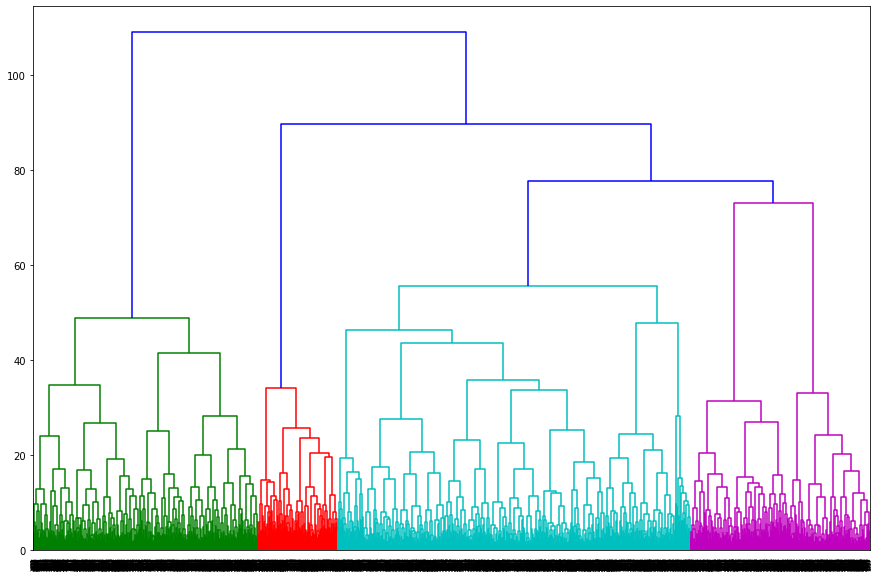

In [ ]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

предположительно имеем 4  кластера, хотя по итогу задачи, минимально необходимое кол-в кластеров - 2 (ушёл или остался). Но большее кол-во кластеров может разбивать клиентов по интересам, которые необходимы для удержания

## 4.3)  кластеризация на основании алгоритма K-Means <a name="k_means_algoritm"></a>

In [ ]:
#кол-во кластеров из ТЗ
n1 = 5

In [ ]:
km = KMeans(n_clusters = n1 , random_state =0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_st)

In [ ]:
df['cluster_mean_5_values'] = labels
#df

получили кластерные признаки. Далее будем их обрабатывать

## 4.4)  средние значения признаков для кластеров <a name="means_clusters"></a>

посмотрим на средние значения для 5-кластерного разбиения:

In [ ]:
df.groupby('cluster_mean_5_values').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,variation_avg_class_frequency
cluster_mean_5_values,,,,,,,,,,,,,,,
0,0.501942,0.959223,0.783495,0.574757,0.999029,10.817476,0.547573,29.947573,161.328226,9.884466,4.730097,1.979266,1.976476,0.028155,0.021362
1,0.541139,0.983122,0.349156,0.239451,1.000000,2.517932,0.465190,30.037975,159.066156,2.331224,4.758439,2.708070,2.714829,0.086498,0.008530
2,0.496063,0.000000,0.458661,0.078740,1.000000,2.342520,0.216535,28.488189,135.815460,2.196850,2.797244,1.675459,1.494075,0.440945,-0.137967
3,0.493357,1.000000,0.349867,0.228521,1.000000,1.925598,0.327724,28.048716,129.761804,1.835252,2.280779,1.189886,0.916295,0.551816,-0.207676
4,0.524675,0.862338,0.470130,0.303896,0.000000,4.758442,0.425974,29.288312,143.679980,4.446753,3.948052,1.858884,1.728031,0.267532,-0.085869


как можем увидеть- кластер 1 и 2 и 3 - почти не имеют оттекающих клиентов. Кластер 4- промежуточный. Кластер 5 - группа риска, за которыми необходимо следить.

Во многих кластерах есть выделяющиеся группы, так, например в признаке "Phone" есть нулевое значение у кластера 4 или, например, в признаке Contract_period в выброс выделился 1 кластер

кластерные группы имеют и одинаковые параметры (например распределение по полу), поэтому мы будем описывать только различия (т.е. то, на что необходимо обращать внимание в первую очередь:
- самый важный для нас параметр- отток - группы 2 и 3 - это категория риска (50 %% оттекающих клиентов), группа 0 и 1 - это "наши" клиенты, а группа 4 - это "неопределившиеся" на которых можно повлиять
- только 2 кластер расположен далеко от фитнеса (этот кластер в зоне риска)
- партнёрскую программу (в том числе и промо акционеры) возглавляет "0" кластер (а это "наши" клиенты)
- телефон не дал только 4 кластер, но рассматривая модели раньше- это не самый важный параметр
- кластер № 0 - это те, кто закзывает самый долгий контракт (так же, это лояльная группа)- остальный, примерно, одинакого. Соответственно, у них самый большой Lifetime  и самое большое кол-во месяцев до конца контракта
- не лаяльные группы (2 и 3) мало ходят на групповые программы (возможно им скучно?) и мало тратят на доп услуги. Так же, они имеют самую редкую посещаемость (в среднем и текущем месяце в частности)


Логично предположить, что для разных групп необходимо поределить разные подходы. Но для их отработки следует провести доп исследование и несколько А-Б тестов. И опять мы упираемся в "чулан" анализируемого предприятия- по силам ли ему вести такие дела, или проще работать "как получится"

## 4.5) распределения признаков для кластеров <a name="plot_clusters"></a>

распределения признаков для 5-и кластерного деления:

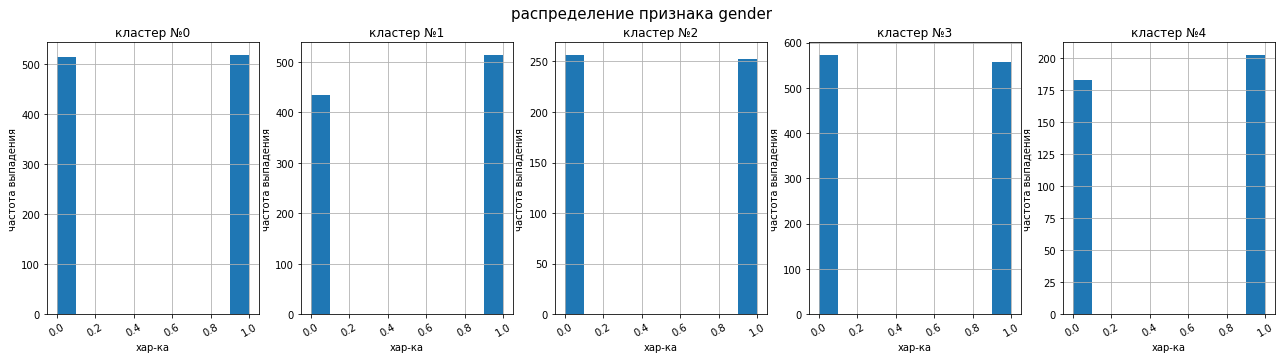

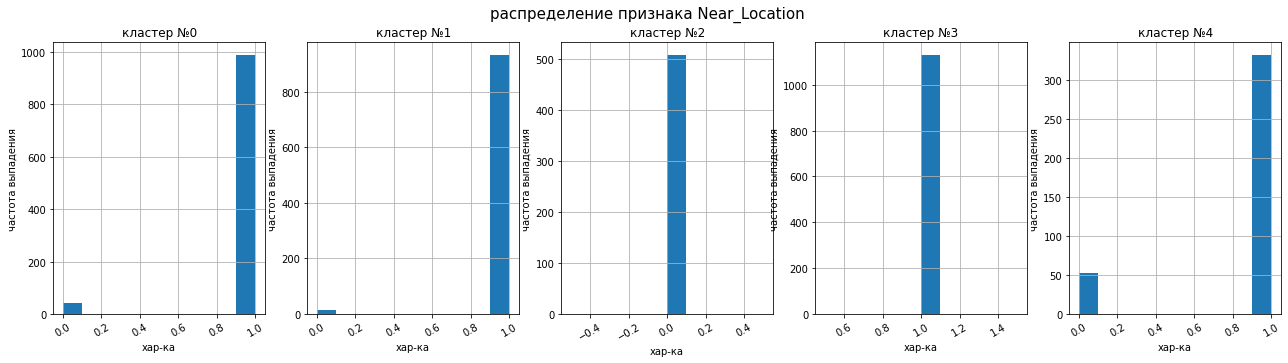

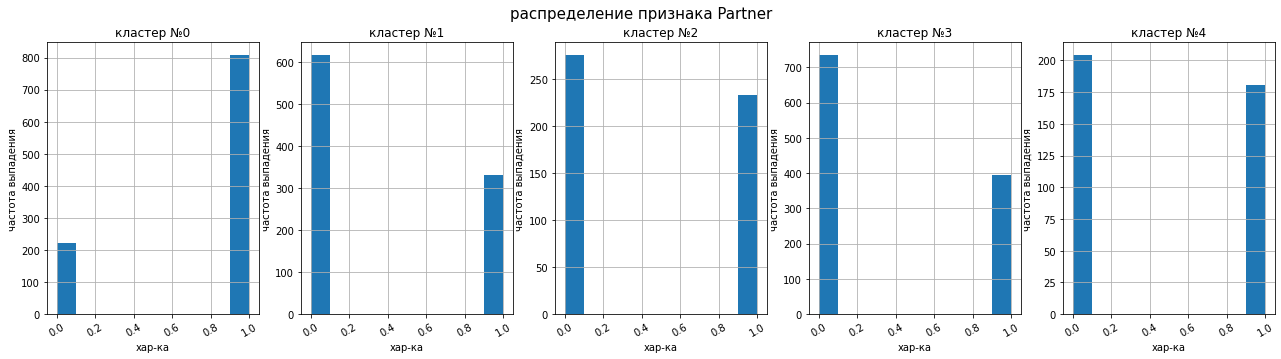

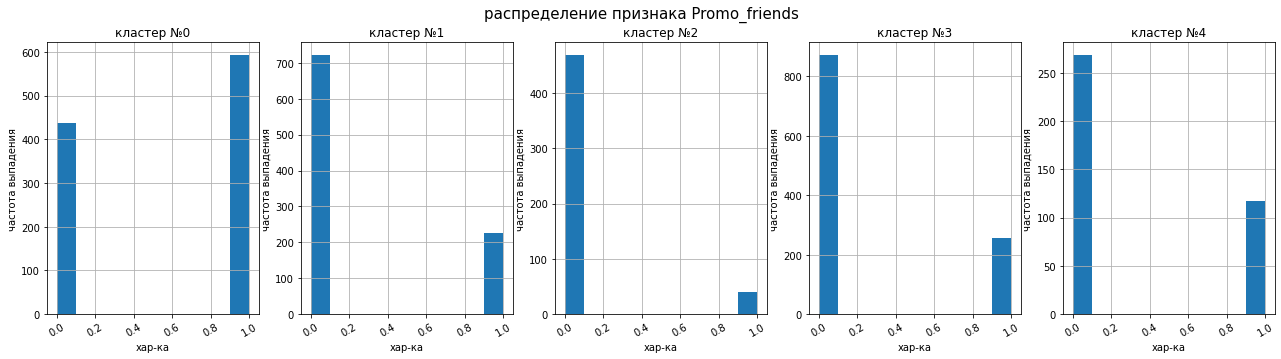

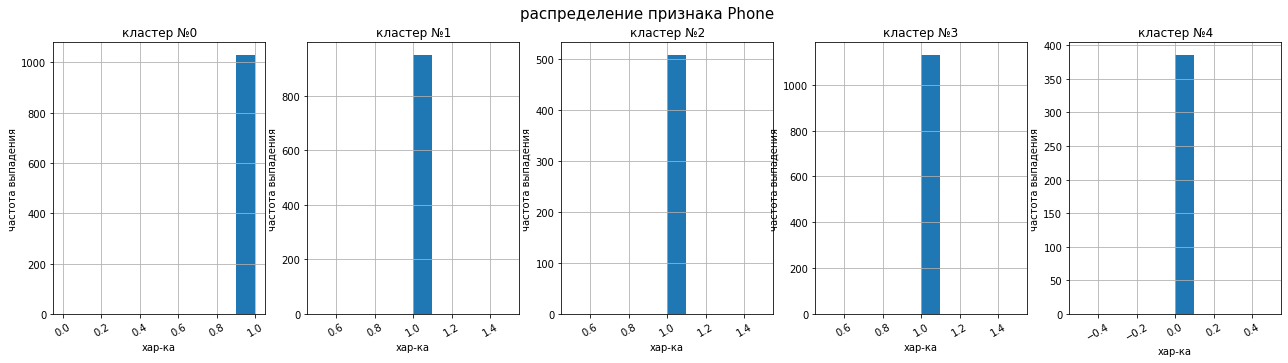

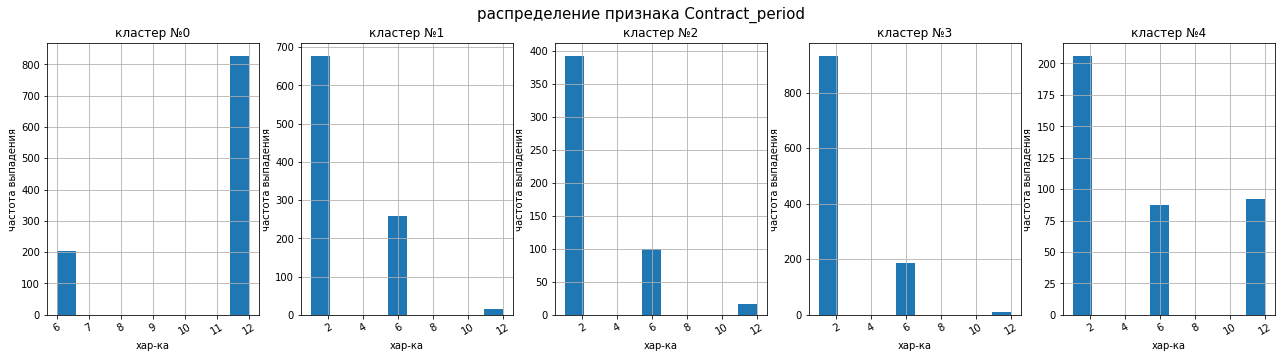

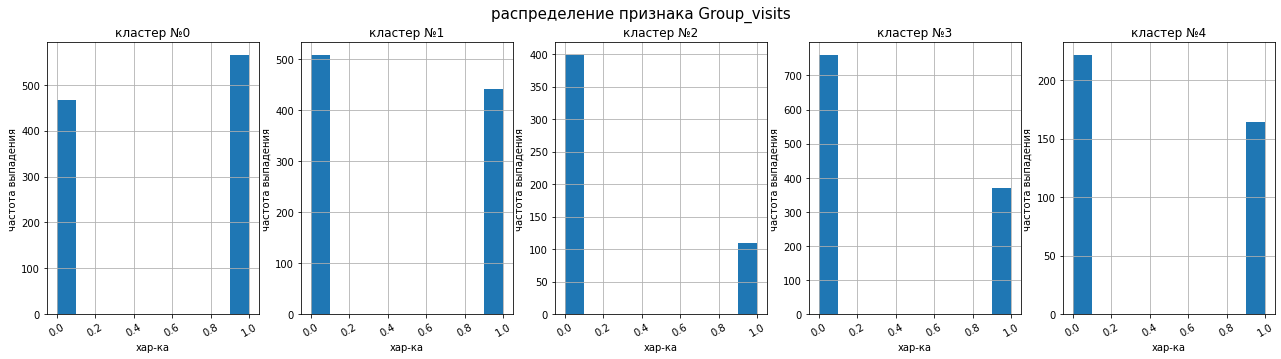

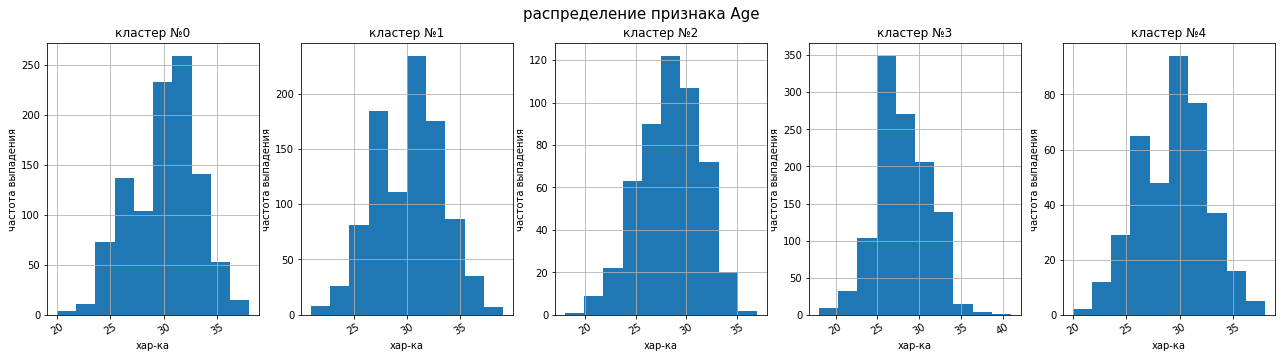

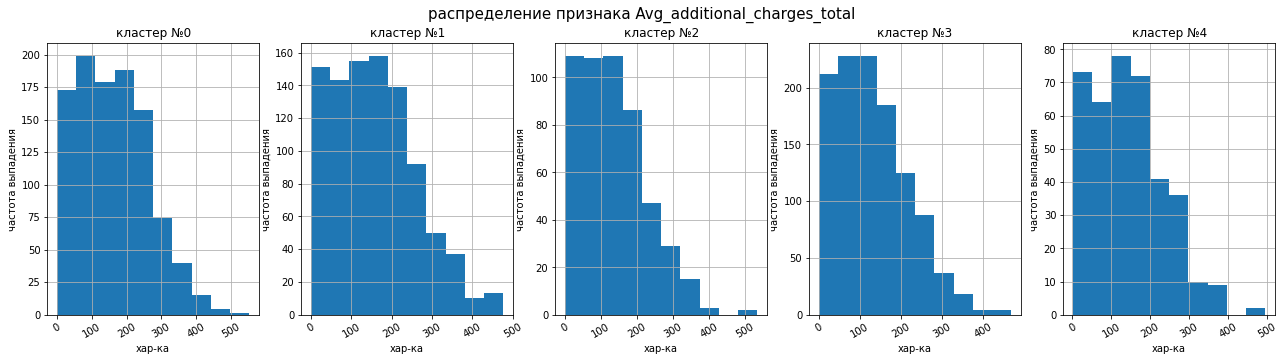

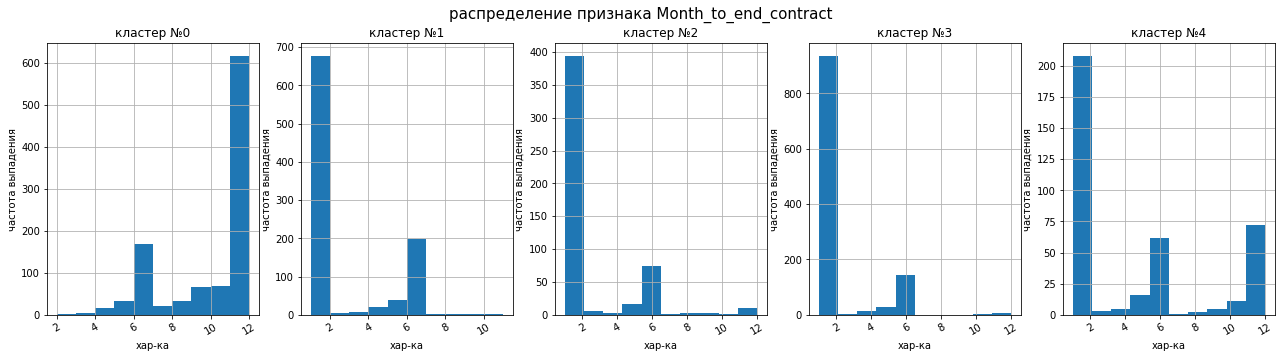

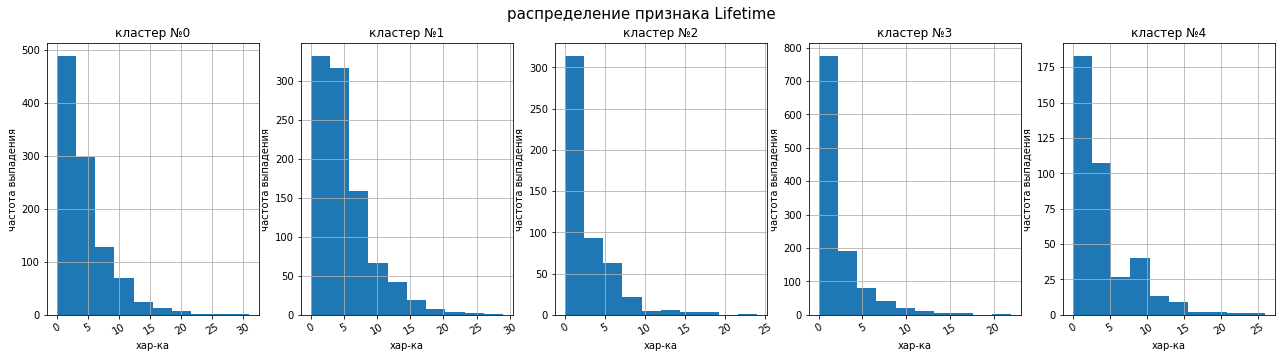

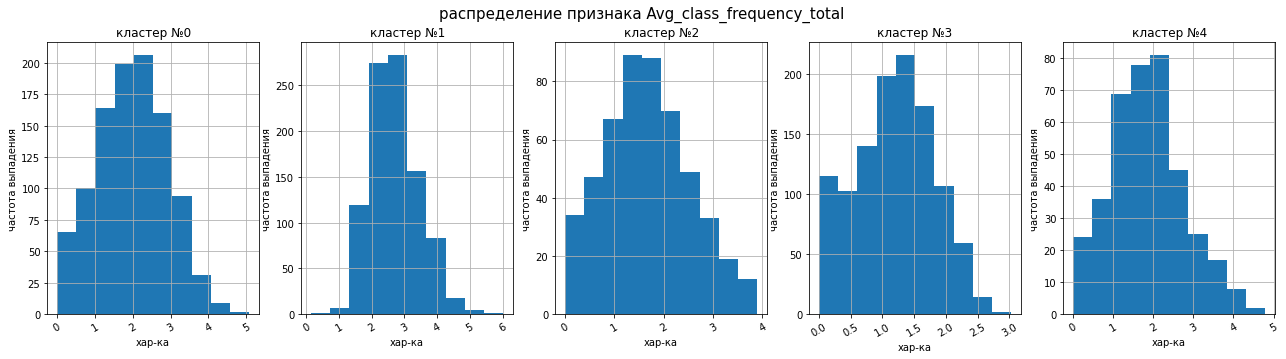

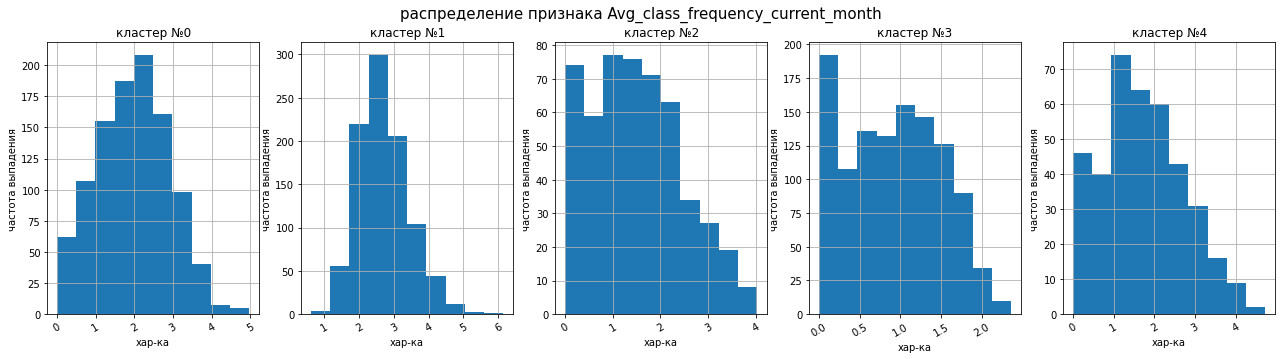

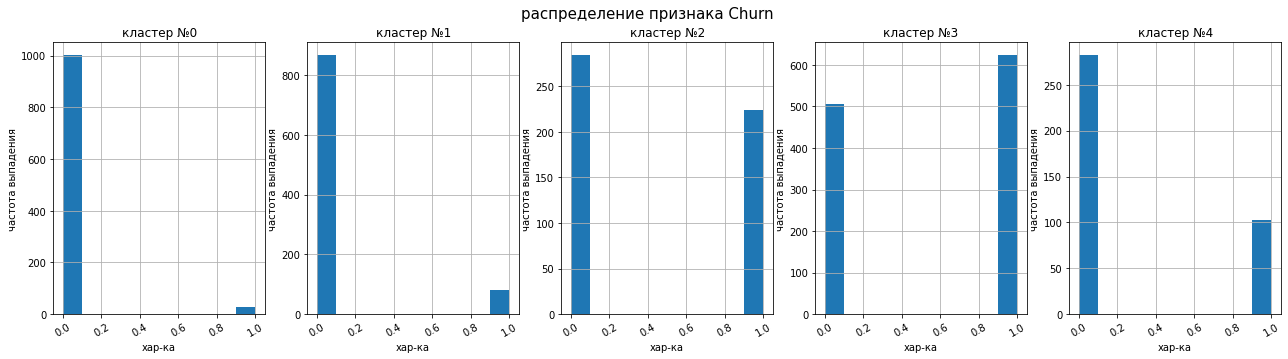

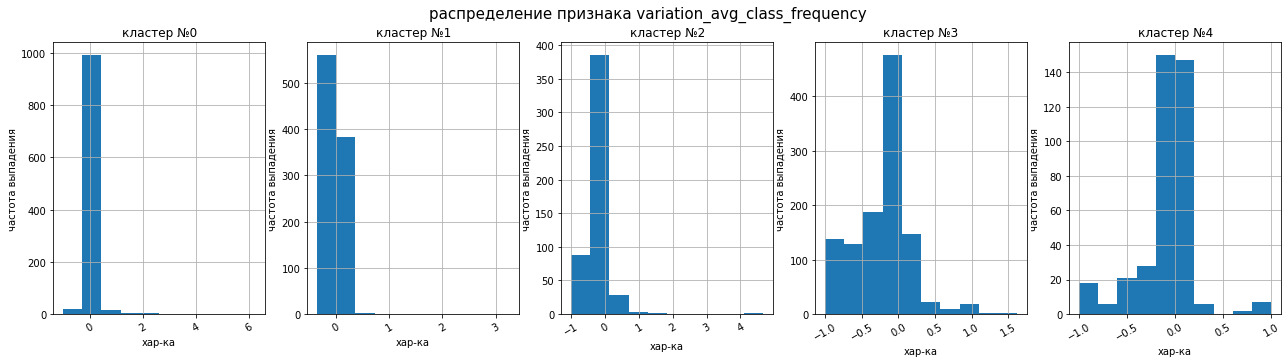

In [ ]:
rasp_graf()

как можно увидеть признаки распределились несколько отлично по разным кластерным группам. Отдельно выделился кластер № 0 в который попала большая доля оттёкших клиентов

## 4.6) доля оттока для каждого кластера <a name="churn_rate_clusters"></a>

In [ ]:
df.groupby('cluster_mean_5_values',  )['Churn'].mean().to_frame().sort_values('Churn', ascending = False).rename(columns = {'Churn': 'part_churn, rel units'})

,"part_churn, rel units"
cluster_mean_5_values,
3,0.551816
2,0.440945
4,0.267532
1,0.086498
0,0.028155


как можем увидеть, появилась очень надёжная кластерная группа (1) с вероятностью оттока 2,3 % и группа, члены которой с очень большой вероятностью отойдут от дел (4 группа- 63%). Остальные группы находятся на приемлемом уровне (10%-25%) и ими можно заниматься в последнюю очередь

# выводы <a name="concusions"></a>

Провели анализ и построение моделей для прогнозирования оттока клиентов. Как и предолагалось- основные критерии, которые можно отслеживать для прогнозирования оттока- частота посещения и уровень долгожительства в конкретном фитнес-центре. Ниже приведены основные параметры, отслеживание которых (в том числе принятие определённых действий на основе уровней данных параметров) может привести к уменьшению уровня оттока клинентов в будущем у увеличению "правильных" клиентов:

#### принципы отбора новык клиентов:

- долгий срок контракта- залог долгого и продуктивного сотрудничества:

Наиболее лояльные клиенты- те, кто готовятся "работать" долго и упорно (заключают "долгие" контракты). Соответственно интересно получать максимально возможное кол-во "работящих" клиентов- за них необходимо бороться с другими фитнес- центрами (например, хорошей программой лояльности и бонусными опциями (сложно говорить о конкретных маркетинговых действиях, не имея информации о текущем экономическом и кадровом составе предприятия)

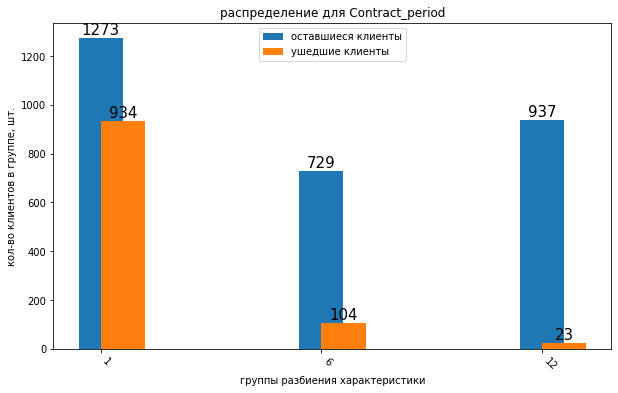

In [ ]:
gist_stroy(df,3, 'Contract_period' ,'upper center', False )

- без царя в голове (проблема отцов и детей):

С точки зрения возрастного состава- наиболее интересна группа постарше (30+ лет). Данная возрастная группа (как показывает практика) способна работать "в долгую" и ей в меньшей степени требуется постоянное изменение обстановки вокруг. Т.е. данная группа более привязана к текущему местоположению, чем более "молодая". Так же, не маловажно, что более "старшая" группа более платёжноспособна, что косвено ведёт к повышению средней выручки за доп услуги


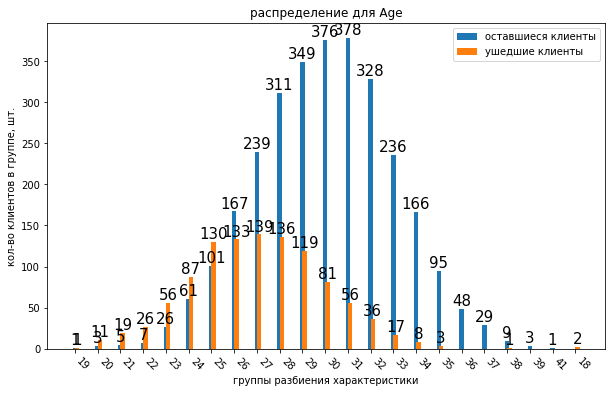

In [ ]:
gist_stroy(df,df['Age'].nunique(), 'Age' , 'upper right', False)

#### надзор за текущими клиентами:

- чем меньше осталось, тем сложнее продолжать:

показатель оттока резко возрастает с уменьшением оставшегося срока контракта. Соовтетсвенно, важно продливать контракт (на максимальный срок (см. пункт выше)) ещё до окончания старого контракта- экономическими, социальными или идейными инструментами (важно знать, что в "чулане" конкретной конторы)

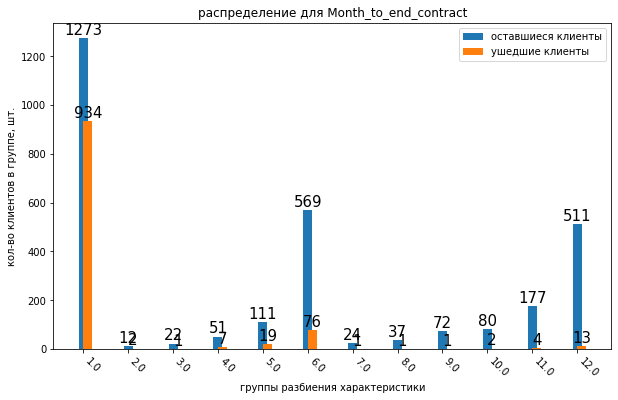

In [ ]:
gist_stroy(df,df['Month_to_end_contract'].nunique(), 'Month_to_end_contract' , 'upper right', False)

- "старожилов" надо выращивать "с молоду":

согласно представленным данным "старожилы" ооттекают сильно меньше остальных групп. Соответсвенно необходимо работать в направлении увеличения кол-ва "старожилов" (см.программу повышения среднего уровня дожития в РФ :) ) Для увеличения уровня страожилов, как вариант, возможно ввести какие- либо бонусы в зависимости от времени сотрудничества и перетягивать к себе "спортсменов" и знаменитых тренеров (они приведут за собой больше новых и "интересных" нам людей)

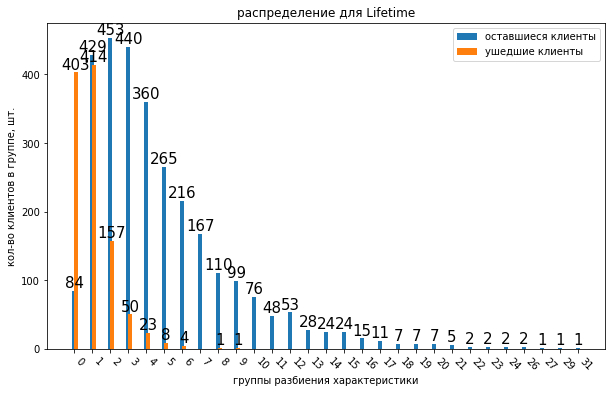

In [ ]:
gist_stroy(df,df['Lifetime'].nunique(), 'Lifetime' , 'upper right', False)

- с хорошими людьми и живётся веселее:

Пришедшие по программе "сотрудничества с другими юр лицами + промо" клиенты более лояльны. Для повышения кол-ва подобных клиентов, вероятно, необходимо увеличивать  взаимодействие по привличению корпоративных клиентов, возможно с оплатой абониментов за счёт работодателя (когда идёт трата денег, которых не видишь физически-тратитть сильно проще)

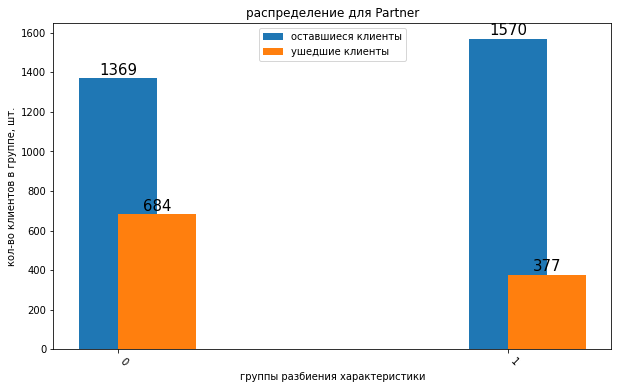

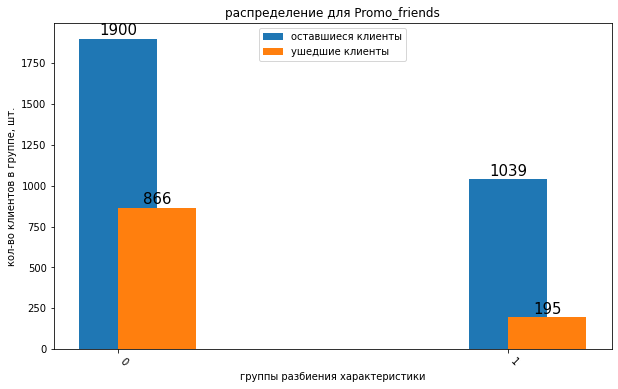

In [ ]:
for i in ('Partner','Promo_friends'):
  gist_stroy(df,2, i , 'upper center', False )

- неотвратимсть наказания влияет больше чем строгость наказания (профилактика важнее наказания):

при падении частоты посещения фитнес-центра резко возрастает вероятность ухода клиента. Соответсвенно, хороший тон- принимать привинтивные меры по удержанию- при отслеживании уменьшения частоты посещения- начинать влиять на клиента опросами и различными бонусами (привет персональным автоматическим скидкам и промо-купонам :) ). НО возможно, клиент уже для себястрого решил уйти- тут важно не переусердствовать, чтобы не потратить "лишних денег" и не уменьшить коллективное мнение о предприятии. Для оптимизации данного подхода необходимо провести доп исследование

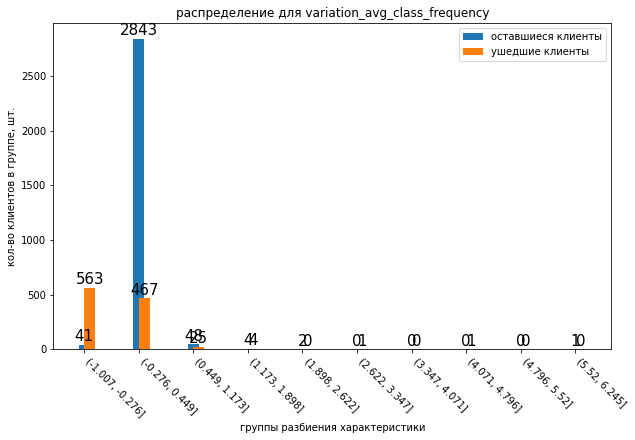

In [ ]:
gist_stroy(df,10, 'variation_avg_class_frequency' , 'upper right', )

---
---
---
Для уточнения "дорожной карты" по каждому пункту- необходимо проводить специально направленные исследования